# **Skenario 1 - CNN VGG16**

Skenario 1 menggunakan model Convolutional Neural Network (CNN) dengan arsitektur VGG16 untuk melakukan klasifikasi pada data citra otak.

---

## 1. Import packages

Import beberapa pustaka seperti `NumPy`, `Pandas`, `Seaborn`, `Matplotlib`, dan `Scikit-learn` untuk analisis data, serta menggunakan `TensorFlow` dan `Keras` untuk mengimplementasikan model deep learning.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# Scikit-learn 
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# TensorFlow and Keras imports
import tensorflow as tf
from keras.utils import to_categorical
from keras.applications import VGG16
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping

## 2. Data Preparation

### 2.1 Load dan Eksplorasi Data

Load data dari image_selected.npz 

In [2]:
def load_and_preprocess_data(preprocess_images=True):
    # Direktori tempat file NPZ disimpan
    base_dir = r"D:\Users\RESA\Coding\Alzheimer-Classification-with-CNN-SVM\Notebook\Preprocessing\image_selected.npz"
    
    # Muat data dari file NPZ
    loaded_data = np.load(base_dir, allow_pickle=True)
    loaded_combined_slices = loaded_data[list(loaded_data.keys())[0]]

    # Daftar untuk data input (X) dan output (Y)
    X = []
    Y = []

    # Buat pemetaan label u/ tiap kelas
    label_mapping = {'AD': 0, 'CN': 1, 'EMCI': 2, 'LMCI': 3}

    # Iterasi melalui data yang diload
    for label, plane_slices in loaded_combined_slices.item().items():
        for plane, slices in plane_slices.items():
            for selected_slice in slices:
                position, original_slice = selected_slice

                if preprocess_images:
                    # Perluas dimensi dan ulangi untuk representasi RGB
                    original_slice = np.expand_dims(original_slice, axis=-1)
                    original_slice = np.repeat(original_slice, 3, axis=-1)

                    # Penskalaan Min-Max untuk membawa nilai piksel ke dalam rentang [0, 1]
                    min_val = np.min(original_slice)
                    max_val = np.max(original_slice)
                    original_slice = (original_slice - min_val) / (max_val - min_val)

                X.append(original_slice)
                Y.append(label_mapping[label])

    # Konversi daftar menjadi array NumPy
    X = np.array(X) 
    Y = np.array(Y, dtype=int)  # Konversi label menjadi bilangan bulat

    return X, Y


In [3]:
# Panggil fungsi dan simpan ke X, Y
X, Y = load_and_preprocess_data(preprocess_images=True)

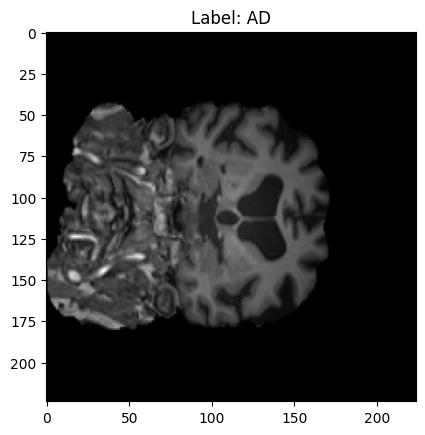

In [4]:
index_to_visualize = 0
image_to_visualize = X[index_to_visualize]
label_to_visualize = Y[index_to_visualize]

class_names = {0: 'AD', 1: 'CN', 2: 'EMCI', 3: 'LMCI'}
label_to_visualize = class_names[np.argmax(label_to_visualize)]

plt.imshow(image_to_visualize)
plt.title(f"Label: {label_to_visualize}")
plt.imshow(image_to_visualize, cmap='gray')

### 2.2 Pembagian Data
Data dibagi dengan rasio 80:20 

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

cek shape dan jumlah data

In [6]:
print("Dimensi X_train:", X_train.shape)
print("Dimensi Y_train:", Y_train.shape)
print("Dimensi X_test:", X_test.shape)
print("Dimensi Y_test:", Y_test.shape)

Dimensi X_train: (5760, 224, 224, 3)
Dimensi Y_train: (5760,)
Dimensi X_test: (1440, 224, 224, 3)
Dimensi Y_test: (1440,)


## 3. Buat dan Konfigurasi Model
Arsitektur yang digunakan yaitu VGG16 sebagai bagian dari transfer learning yaitu arsitektur yang sudah dilatih dengan data ImageNet

In [7]:
def create_model():
    inputs = Input(shape=(224, 224, 3))

    # Pakai model VGG16 sbg base model
    base_model = VGG16(
        weights='imagenet',
        input_tensor=inputs,
        include_top=False,
        input_shape=(224, 224, 3) 
    )
    x = base_model.output
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dense(4096, activation='relu')(x)
    outputs = Dense(4, activation='softmax')(x)

    model = Model(inputs, outputs)

    # Mengatur agar semua lapisan model dasar gabisa di-train
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']     

mendefinisikan dua fungsi, specificity dan sensitivity

In [8]:
import keras.backend as K

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', specificity, sensitivity])

## 4. Training Model

Inisialisasi `StratifiedKFold` dengan 5 lipatan, dan mengatur callback `Early Stopping `dan `Model Checkpoint` untuk digunakan selama pelatihan model

In [9]:
n_splits = 5 
# Inisialisasi StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)  

# Tentukan callback Early Stopping dan Model Checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(r'D:\Users\RESA\Coding\Model\M_VGG16.h5', monitor='val_loss', save_best_only=True)

Melatih dan mengevaluasi model pada setiap lipatan (fold) menggunakan `Stratified K-Fold cross-validation`, menyimpan metrik hasil evaluasi 

In [10]:
# List untuk menyimpan metrik dan riwayat model untuk setiap fold
accuracy_per_fold = []
precision_per_fold = []
recall_per_fold = []
f1_score_per_fold = []
roc_auc_per_fold = []
model_history_per_fold = []

for fold, (train_index, test_index) in enumerate(skf.split(X, Y)):
    print(f"Training on Fold: {fold+1}/{n_splits}...")

    # Split data menjadi data train dan test untuk setiap fold
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    # Buat model untuk setiap fold
    model = create_model()

    # Latih model dengan menggunakan Early Stopping dan Model Checkpoint callbacks
    history = model.fit(
        X_train, to_categorical(Y_train, num_classes=len(set(Y))),
        epochs=25, batch_size=32,
        validation_data=(X_test, to_categorical(Y_test, num_classes=len(set(Y)))),
        callbacks=[early_stopping, model_checkpoint]
    )

    # Evaluasi model pada data test untuk setiap lipatan
    Y_test_pred = model.predict(X_test)
    Y_test_pred_classes = np.argmax(Y_test_pred, axis=1)

    # Hitung metrik
    accuracy_per_fold.append(accuracy_score(Y_test, Y_test_pred_classes))
    precision_per_fold.append(precision_score(Y_test, Y_test_pred_classes, average='weighted'))
    recall_per_fold.append(recall_score(Y_test, Y_test_pred_classes, average='weighted'))
    f1_score_per_fold.append(f1_score(Y_test, Y_test_pred_classes, average='weighted'))

    # Label biner menggunakan LabelBinarizer
    lb = LabelBinarizer()
    Y_test_binary = lb.fit_transform(Y_test)
    Y_test_pred_binary = lb.transform(Y_test_pred_classes)

    # Hitung ROC AUC untuk setiap kelas
    roc_auc_fold = []
    for i in range(len(lb.classes_)):
        fpr, tpr, _ = roc_curve(Y_test_binary[:, i], Y_test_pred_binary[:, i])
        roc_auc = auc(fpr, tpr)
        roc_auc_fold.append(roc_auc)

    roc_auc_per_fold.append(roc_auc_fold)

    model_history_per_fold.append(history)

    # Cetak laporan klasifikasi untuk setiap lipatan
    classification_rep = classification_report(Y_test, Y_test_pred_classes)
    print(f"Laporan Klasifikasi untuk Lipatan {fold+1}:\n{classification_rep}")


Training on Fold: 1/5...
Epoch 1/25


180/180 [==============================] - ETA: 0s - loss: 1.3880 - accuracy: 0.3538

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


180/180 [==============================] - 40s 208ms/step - loss: 1.3880 - accuracy: 0.3538 - val_loss: 1.2216 - val_accuracy: 0.4326
Epoch 2/25
180/180 [==============================] - 34s 188ms/step - loss: 1.1720 - accuracy: 0.4793 - val_loss: 1.1809 - val_accuracy: 0.4729
Epoch 3/25
180/180 [==============================] - 34s 187ms/step - loss: 1.0227 - accuracy: 0.5717 - val_loss: 1.0920 - val_accuracy: 0.5257
Epoch 4/25
180/180 [==============================] - 33s 186ms/step - loss: 0.8746 - accuracy: 0.6340 - val_loss: 0.9411 - val_accuracy: 0.5938
Epoch 5/25
180/180 [==============================] - 34s 187ms/step - loss: 0.7392 - accuracy: 0.7087 - val_loss: 0.8435 - val_accuracy: 0.6681
Epoch 6/25
180/180 [==============================] - 34s 187ms/step - loss: 0.6290 - accuracy: 0.7524 - val_loss: 0.7293 - val_accuracy: 0.7042
Epoch 7/25
180/180 [==============================] - 32s 178ms/step - loss: 0.5434 - accuracy: 0.7941 - val_loss: 0.8558 - val_accuracy: 0.6

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


180/180 [==============================] - 35s 193ms/step - loss: 0.3682 - accuracy: 0.8618 - val_loss: 0.5717 - val_accuracy: 0.7910
Epoch 10/25
180/180 [==============================] - 32s 178ms/step - loss: 0.3176 - accuracy: 0.8785 - val_loss: 0.5901 - val_accuracy: 0.7764
Epoch 11/25
180/180 [==============================] - 32s 179ms/step - loss: 0.2744 - accuracy: 0.8944 - val_loss: 0.6484 - val_accuracy: 0.7896
Epoch 12/25
180/180 [==============================] - 33s 181ms/step - loss: 0.2029 - accuracy: 0.9285 - val_loss: 0.6227 - val_accuracy: 0.7889
Epoch 13/25
180/180 [==============================] - 33s 181ms/step - loss: 0.2068 - accuracy: 0.9217 - val_loss: 0.6772 - val_accuracy: 0.7917
Epoch 14/25
45/45 [==============================] - 7s 142ms/step
Laporan Klasifikasi untuk Lipatan 4:
              precision    recall  f1-score   support

           0       0.86      0.83      0.84       360
           1       0.80      0.77      0.78       360
           2   

## 4. Testing

Test Data

In [11]:
evaluation_result = model.evaluate(X_test, to_categorical(Y_test, num_classes=4), verbose=1)

# Menampilkan hasil evaluasi
print("Loss:", evaluation_result[0])
print("Accuracy:", evaluation_result[1])

# Prediksi menggunakan data uji
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

print('Label Sebenarnya : ', Y_test)
print('Label Prediksi : ', predicted_labels)

45/45 [==============================] - 6s 139ms/step - loss: 0.6002 - accuracy: 0.7889
Loss: 0.6002374291419983
Accuracy: 0.7888888716697693
45/45 [==============================] - 6s 142ms/step
Label Sebenarnya :  [0 0 0 ... 3 3 3]
Label Prediksi :  [0 3 0 ... 3 3 2]


## 5. Evaluasi dan Visualisasi

Evaluasi model yang telah diuji

In [15]:
# Find the fold with the best validation loss
best_fold = np.argmin([history.history['val_loss'][-1] for history in model_history_per_fold])

# Retrieve the model with the best performance
best_model = create_model()
best_model.set_weights(model_history_per_fold[best_fold].model.get_weights())

# Evaluate the best model on the validation set
Y_test_pred_best = best_model.predict(X_test)
Y_test_pred_classes_best = np.argmax(Y_test_pred_best, axis=1)

45/45 [==============================] - 6s 129ms/step


classification report

In [16]:
classification_rep_best = classification_report(Y_test, Y_test_pred_classes_best)
print(f"Best Model - Classification Report:\n{classification_rep_best}")

Best Model - Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       360
           1       0.93      0.91      0.92       360
           2       0.87      0.95      0.91       360
           3       0.93      0.89      0.91       360

    accuracy                           0.93      1440
   macro avg       0.93      0.92      0.93      1440
weighted avg       0.93      0.93      0.93      1440



confusion matrix

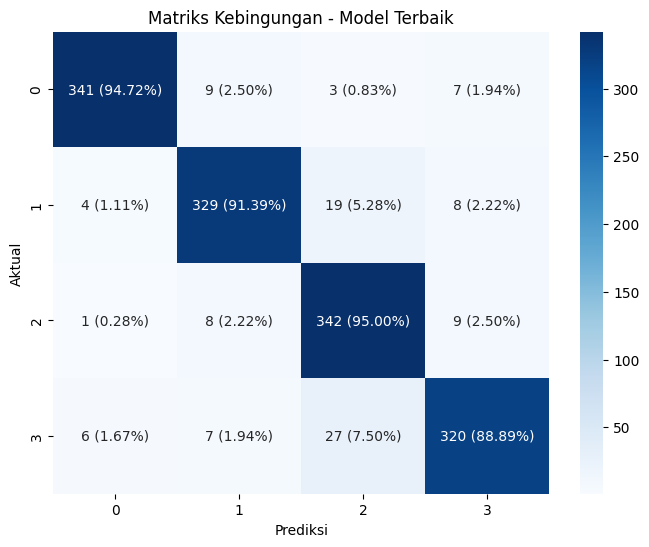

In [17]:
# Hitung confusion matrix u/ model terbaik
conf_matrix_best = confusion_matrix(Y_test, Y_test_pred_classes_best)

# Normalisasi confusion matrux untuk mendapatkan persentase
conf_matrix_percentage = conf_matrix_best.astype('float') / conf_matrix_best.sum(axis=1)[:, np.newaxis]

# Buat anotasi kustom
annotations = [['{} ({:.2%})'.format(value, percentage) for value, percentage in zip(row, row_percentage)]
               for row, row_percentage in zip(conf_matrix_best, conf_matrix_percentage)]

# Plot conf matrix dgn anotasi kustom
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_best, annot=annotations, fmt='', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriks Kebingungan - Model Terbaik')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()


In [18]:
# Jmlh kelas dalam data test
num_classes = len(set(Y_test))

# List untuk nyimpen sensitivitas dan spesifisitas /kelas
sensitivity = []
specificity = []

# Iterasi untuk tiap kelas
for i in range(num_classes):
    # True Positive (tp), False Negative (fn), False Positive (fp), True Negative (tn)
    tp = conf_matrix_best[i, i]
    fn = np.sum(conf_matrix_best[i, :]) - tp
    fp = np.sum(conf_matrix_best[:, i]) - tp
    tn = np.sum(conf_matrix_best) - tp - fn - fp

    # Hitung sensitivitas & spesifisitas
    sensitivity.append(tp / (tp + fn))
    specificity.append(tn / (tn + fp))

print("Sensitivitas per kelas:", sensitivity)
print("Spesifisitas per kelas:", specificity)


Sensitivitas per kelas: [0.9472222222222222, 0.9138888888888889, 0.95, 0.8888888888888888]
Spesifisitas per kelas: [0.9898148148148148, 0.9777777777777777, 0.9546296296296296, 0.9777777777777777]


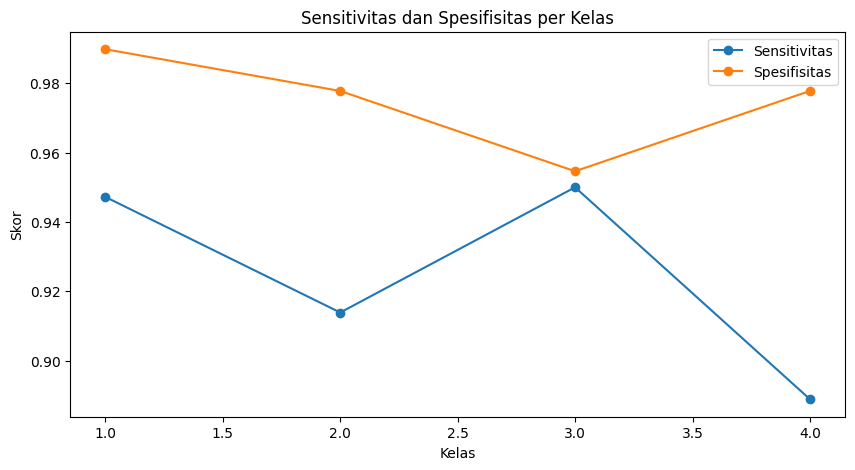

In [19]:
# Jmlh kelas yg digunakan
num_classes = len(sensitivity)

# Plotting sensitivitas dan spesifisitas pd grafik yang sama
plt.figure(figsize=(10, 5))

# Plot sensitivitas
plt.plot(range(1, num_classes + 1), sensitivity, marker='o', linestyle='-', label='Sensitivitas')

# Plot spesifisitas
plt.plot(range(1, num_classes + 1), specificity, marker='o', linestyle='-', label='Spesifisitas')

plt.title('Sensitivitas dan Spesifisitas per Kelas')
plt.xlabel('Kelas')
plt.ylabel('Skor')
plt.legend()
plt.show()

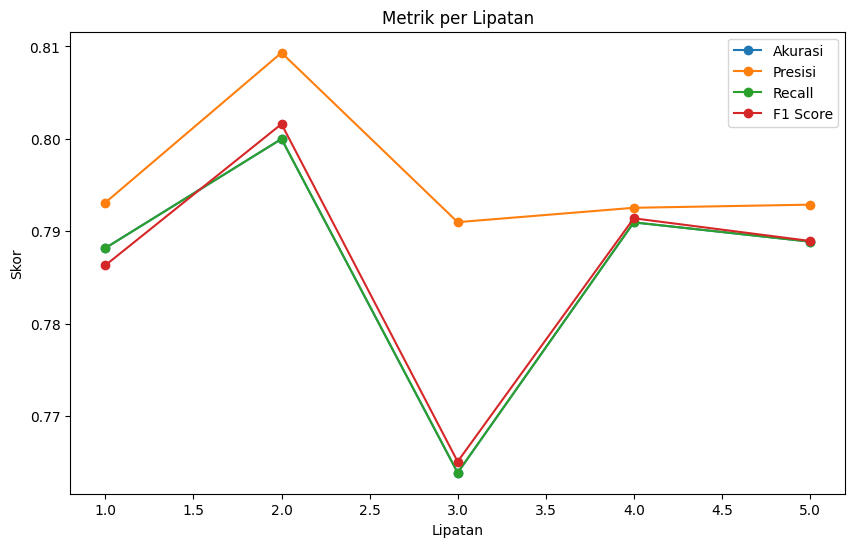

In [20]:
# Jumlah lipatan yang digunakan
n_folds = len(accuracy_per_fold)

# Plot semua metrik dlm satu grafik
plt.figure(figsize=(10, 6))

# Plot akurasi
plt.plot(range(1, n_folds + 1), accuracy_per_fold, marker='o', label='Akurasi')

# Plot presisi
plt.plot(range(1, n_folds + 1), precision_per_fold, marker='o', label='Presisi')

# Plot recall
plt.plot(range(1, n_folds + 1), recall_per_fold, marker='o', label='Recall')

# Plot F1 score
plt.plot(range(1, n_folds + 1), f1_score_per_fold, marker='o', label='F1 Score')

plt.title('Metrik per Lipatan')
plt.xlabel('Lipatan')
plt.ylabel('Skor')
plt.legend()
plt.show()

In [28]:
class_names = ["AD", "CN", "EMCI", "LMCI"]

In [30]:
for fold, roc_auc_fold in enumerate(roc_auc_per_fold):
    for i, auc_value in enumerate(roc_auc_fold):
        print(f"ROC AUC untuk Lipatan {fold+1}, Kelas {class_names[i]}: {auc_value}")

ROC AUC untuk Lipatan 1, Kelas AD: 0.9087962962962962
ROC AUC untuk Lipatan 1, Kelas CN: 0.811111111111111
ROC AUC untuk Lipatan 1, Kelas EMCI: 0.8634259259259258
ROC AUC untuk Lipatan 1, Kelas LMCI: 0.8518518518518519
ROC AUC untuk Lipatan 2, Kelas AD: 0.8875
ROC AUC untuk Lipatan 2, Kelas CN: 0.8546296296296296
ROC AUC untuk Lipatan 2, Kelas EMCI: 0.8643518518518519
ROC AUC untuk Lipatan 2, Kelas LMCI: 0.860185185185185
ROC AUC untuk Lipatan 3, Kelas AD: 0.8634259259259259
ROC AUC untuk Lipatan 3, Kelas CN: 0.7976851851851852
ROC AUC untuk Lipatan 3, Kelas EMCI: 0.8481481481481481
ROC AUC untuk Lipatan 3, Kelas LMCI: 0.8611111111111109
ROC AUC untuk Lipatan 4, Kelas AD: 0.8921296296296298
ROC AUC untuk Lipatan 4, Kelas CN: 0.8504629629629629
ROC AUC untuk Lipatan 4, Kelas EMCI: 0.8453703703703703
ROC AUC untuk Lipatan 4, Kelas LMCI: 0.8546296296296295
ROC AUC untuk Lipatan 5, Kelas AD: 0.8726851851851852
ROC AUC untuk Lipatan 5, Kelas CN: 0.8375
ROC AUC untuk Lipatan 5, Kelas EMCI: 0

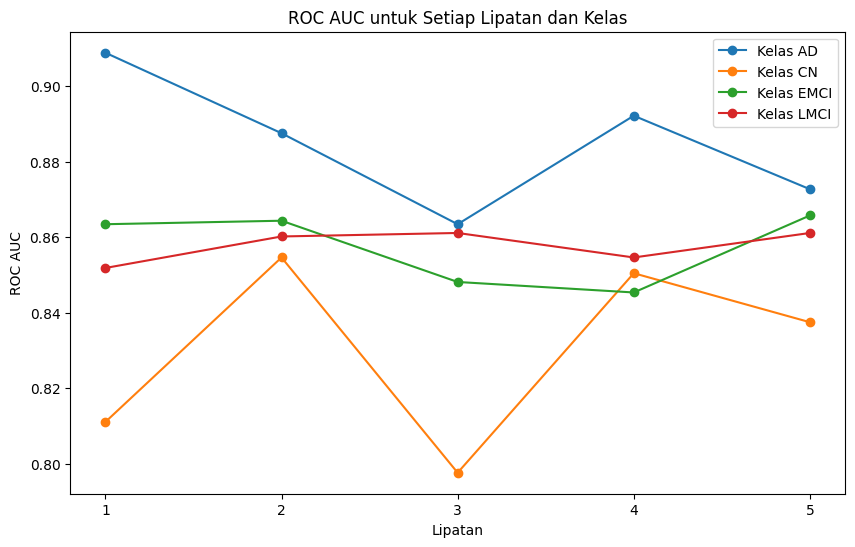

In [34]:
n_folds = len(roc_auc_per_fold)
n_classes = len(class_names)

# Data untuk plotting
data = np.array(roc_auc_per_fold)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Membuat garis untuk setiap kelas
for i in range(n_classes):
    ax.plot(range(1, n_folds + 1), data[:, i], marker='o', label=f'Kelas {class_names[i]}')

ax.set_xlabel('Lipatan')
ax.set_ylabel('ROC AUC')
ax.set_title('ROC AUC untuk Setiap Lipatan dan Kelas')
ax.set_xticks(range(1, n_folds + 1)) 
ax.legend()

plt.show()

In [ ]:
# Cetak average ROC AUC
average_roc_auc = np.mean(roc_auc_per_fold)
print(f'Average ROC AUC: {average_roc_auc:.2f}')